In [19]:
import numpy as np
from numba import *
from scipy import stats
from astropy import units
from itertools import product
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize

In [2]:
# from Oskari's Beam Characterization report
vcm = 184
vcm_sigma = 16.8
vt_sigma = 93/(2*np.sqrt(2*np.log(2))) # from FWHM

# coordinate width, adapted from ACME to CeNTREX based on email from Xing Wu on 6-10-2020
sigma_width = 0.25*25.4/5 * 3.8e-3

v_acceptable = 1.5 # m/s

v_laser = 1.5 # m/s, molecules the laser can interact with
r_laser = 5e-3 # m

spawn molecules in a circle with a $1-\sigma$ width of $6/5\cdot 3.8$mm cm diameter at 1 cm distance from the cell. 
ACME measured a $1-\sigma$ width of 3.8 mm, 1 cm from the cell opening, with a cell aperture diameter of 5 mm.

In [3]:
generate_random_r = lambda x: np.random.normal(0,sigma_width,x)
generate_random_longitudinal_velocities = lambda x: np.random.normal(vcm, vcm_sigma, x)
generate_random_transverse_velocities = lambda x: np.random.normal(0, vt_sigma, x)

def generate_random_coords(size):
    xy = np.empty([2,size])
    xy[0,:] = generate_random_r(size)
    xy[1,:] = generate_random_r(size)
    return xy
            
def generate_random_transverse_velocities(size):
    v_transverse = np.random.multivariate_normal([0,0],np.array([[vt_sigma**2,0],[0,vt_sigma**2]]),size).T
    return v_transverse

In [4]:
size = int(1e8)
coords = generate_random_coords(size)
v_z = generate_random_longitudinal_velocities(size)
v_x, v_y = generate_random_transverse_velocities(size)

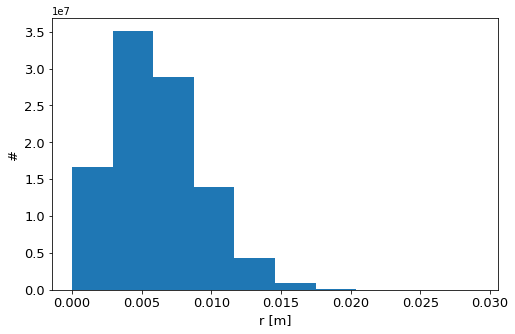

In [5]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.sqrt(np.sum(coords**2, axis = 0)))
ax.set_xlabel('r [m]')
ax.set_ylabel('#')

set_fontsize(ax, 13)

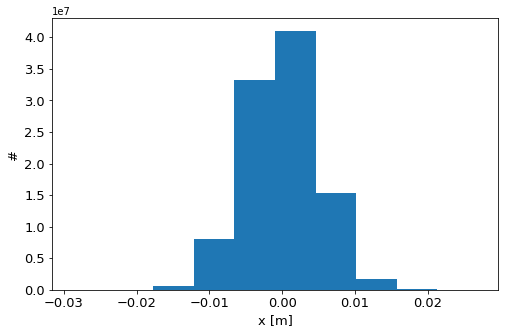

In [6]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(coords[0,:])
ax.set_xlabel('x [m]')
ax.set_ylabel('#')

set_fontsize(ax, 13)

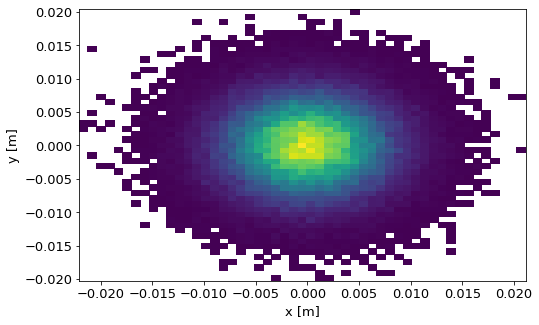

In [7]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist2d(coords[0,:][:int(1e5)],coords[1,:][:int(1e5)], bins = [51,51], cmin = 1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

set_fontsize(ax, 13)

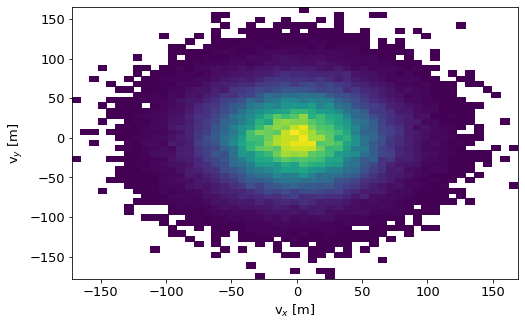

In [8]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist2d(v_x[:int(1e5)], v_y[:int(1e5)], bins = [51,51], cmin = 1)
ax.set_xlabel(r'v$_x$ [m]')
ax.set_ylabel(r'v$_y$ [m]')

set_fontsize(ax, 13)

### Without Aperture
Without an aperture there are several transverse velocity limiting components in the beamline.  
The closest to the rotational cooling chamber is the entrance flange, where the 1st colimator would also be placed.
The distance from the assumed extended source of this component is 17.36" - 1 cm, and the opening diameter is 60 mm.

In [9]:
in_to_m = (units.imperial.inch).to(units.m)

In [10]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

filtered = np.empty([3,size])

dt = distance_aperture_1/v_z
filtered[0,:] = coords[0,:]+dt*v_x
filtered[1,:] = coords[1,:]+dt*v_y
filtered[2,:] = distance_aperture_1

m = np.sqrt(np.sum(filtered[:2,:]**2, axis = 0)) < 60/2 * 1e-3
size = m.sum()

v_x_full, v_y_full, v_z_full = v_x.copy(), v_y.copy(), v_z.copy()
v_x, v_y, v_z = v_x[m], v_y[m], v_z[m]

coords_full = coords.copy()
coords = np.empty([2,size])
coords[0,:] = coords_full[0,:][m]
coords[1,:] = coords_full[1,:][m]


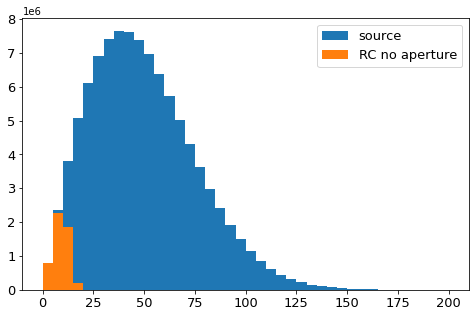

In [11]:
dx = 5
b = np.arange(0,200+dx,dx)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.sqrt(v_x_full**2+v_y_full**2), bins = b, label = 'source')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = b, label = 'RC no aperture')
ax.legend(fontsize = 13)
set_fontsize(ax, 13)

distance to RC laser from cell opening is 21.75"  
distance to aperture #1 from cell opening is 17.36"  

distance to LIF laser from cell opening is 38.39"  
distance to aperture #2 from cel opening is 31" (estimate, check in setup) 

In [12]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

coords_aperture_1 = np.empty([3,size])

dt = distance_aperture_1/v_z
coords_aperture_1[0,:] = coords[0,:]+dt*v_x
coords_aperture_1[1,:] = coords[1,:]+dt*v_y
coords_aperture_1[2,:] = distance_aperture_1

In [13]:
distance_aperture_2 = 31 * in_to_m - 0.01

coords_aperture_2 = np.empty([3,size])

dt = distance_aperture_2/v_z
coords_aperture_2[0,:] = coords[0,:]+dt*v_x
coords_aperture_2[1,:] = coords[1,:]+dt*v_y
coords_aperture_2[2,:] = distance_aperture_2

In [14]:
distance_laser_rc = 21.75 * in_to_m - 0.01
dt = distance_laser_rc/v_z

m_interaction_rc = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_rc = np.sum(m_interaction_rc)


coords_rc = np.empty([3,size])

coords_rc[0,:] = coords[0,:]+dt*v_x
coords_rc[1,:] = coords[1,:]+dt*v_y
coords_rc[2,:] = distance_laser_rc

In [15]:
distance_laser_lif = 38.30 * in_to_m - 0.01
dt = distance_laser_lif/v_z

m_iteraction_lif = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_lif = np.sum(m_iteraction_lif)

coords_lif = np.empty([3,size])

coords_lif[0,:] = coords[0,:]+dt*v_x
coords_lif[1,:] = coords[1,:]+dt*v_y
coords_lif[2,:] = distance_laser_lif

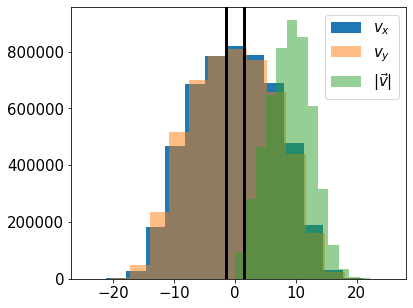

In [16]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$')
ax.hist(v_y, bins = bins, alpha = 0.5, label = r'$v_y$')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = bins, alpha = 0.5, label = r'$|\vec{v}|$')

ax.legend(fontsize = 15)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 15)

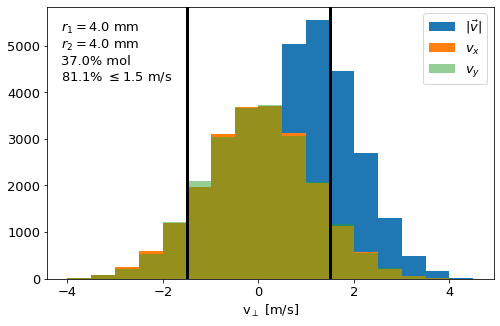

In [17]:
r1 = 4e-3
r2 = 4e-3

bins = np.arange(-4,4+1,0.5)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

ax.hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, label = r'$|\vec{v}|$')
ax.hist(v_x[m], bins = bins, label = r'$v_x$')
ax.hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$')

ax.legend(fontsize = 13, loc = 1)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')

ax.set_xlabel(r'v$_\perp$ [m/s]')

set_fontsize(ax, 13)
    
dt = distance_laser_lif/v_z[m]
m_interact = (np.abs(coords[1,:][m]+dt*v_y[m]) <= r_laser) & (np.abs(v_x[m]) <= v_laser)
interact = m_interact.sum()/interaction_lif*100

text = f'$r_1 = ${r1*1e3:.1f} mm'+'\n'
text += f'$r_2 = ${r2*1e3:.1f} mm'+'\n'
text += f'{m.sum()/interaction_lif*100:.1f}% mol'+'\n'
text += f'{(100*(np.abs(v_x[m]) < v_acceptable).sum()/m.sum()):.1f}% $\leq {v_acceptable}$ m/s'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 13);

RC laser heigh distribution $4\sigma$ width is 5 mm

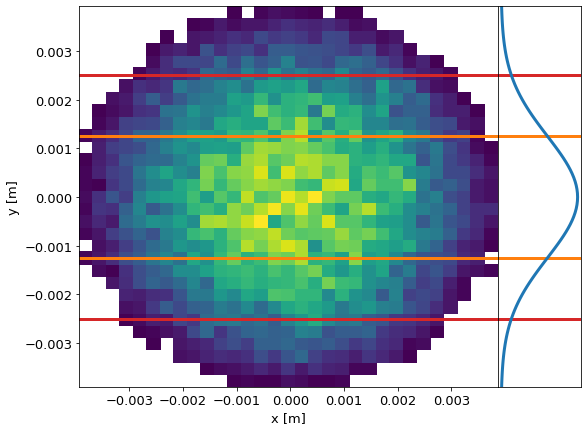

In [20]:
fig = plt.figure(figsize=(9,7))
gs = fig.add_gridspec(nrows = 6, ncols = 6, wspace = 0, hspace = 0)
ax = fig.add_subplot(gs[:6,:5])
axy = fig.add_subplot(gs[:6,5:], sharey = ax)

axy.get_xaxis().set_visible(False)
axy.get_yaxis().set_visible(False)

ax.hist2d(coords_rc[0,:][m], coords_rc[1,:][m], bins = [31,31], cmin = 1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

σlaser = 5e-3/4
ax.axhline(σlaser, color = 'C1', lw = 3, linestyle = '-')
ax.axhline(-σlaser, color = 'C1', lw = 3, linestyle = '-')
ax.axhline(2*σlaser, color = 'C3', lw = 3, linestyle = '-')
ax.axhline(-2*σlaser, color = 'C3', lw = 3, linestyle = '-')

norm = stats.norm(loc = 0, scale = σlaser)
x = np.linspace(-0.004, 0.004, 101)

axy.plot(norm.pdf(x)/norm.pdf(0), x, lw = 3)
axy.axhline(σlaser, lw = 3, zorder = 0, color = 'C1')
axy.axhline(-σlaser, lw = 3, zorder = 0, color = 'C1')
axy.axhline(2*σlaser, lw = 3, zorder = 0, color = 'C3')
axy.axhline(-2*σlaser, lw = 3, zorder = 0, color = 'C3')

set_fontsize(ax, 13)

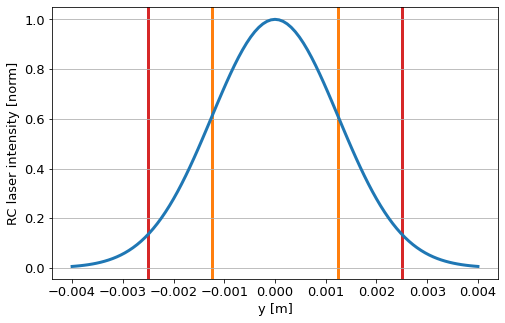

In [21]:
x = np.linspace(-0.004, 0.004, 101)
norm = stats.norm(loc = 0, scale = σlaser)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x, norm.pdf(x)/norm.pdf(0), lw = 3)

ax.axvline(σlaser, lw = 3, zorder = 0, color = 'C1')
ax.axvline(-σlaser, lw = 3, zorder = 0, color = 'C1')
ax.axvline(2*σlaser, lw = 3, zorder = 0, color = 'C3')
ax.axvline(-2*σlaser, lw = 3, zorder = 0, color = 'C3')

ax.grid(axis = 'y')

ax.set_xlabel("y [m]")
ax.set_ylabel('RC laser intensity [norm]')
set_fontsize(ax, 13)

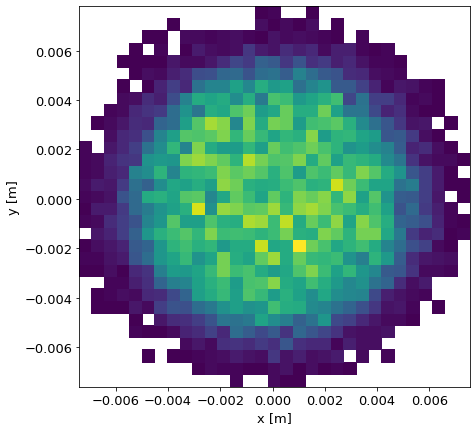

In [22]:
fig, ax = plt.subplots(figsize = (7,7))
ax.hist2d(coords_lif[0,:][m], coords_lif[1,:][m], bins = [31,31], cmin = 1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

set_fontsize(ax, 13)

In [31]:
from scipy import stats

stat_fn = lambda x: np.max(np.abs(x))

stat, x_edge, y_edge, _ = stats.binned_statistic_2d(coords_rc[0,:][m], coords_rc[1,:][m], values = v_x[m], 
                                                    bins = 31, statistic = stat_fn)

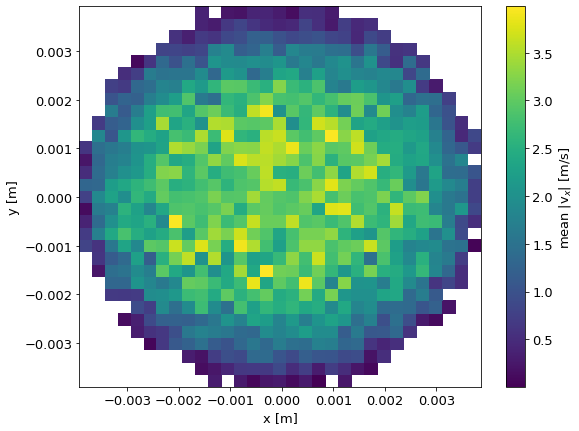

In [32]:
X,Y = np.meshgrid(x_edge, y_edge)

fig, ax = plt.subplots(figsize = (9,7))
cs = ax.pcolormesh(X,Y,stat)
cbar = fig.colorbar(cs)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
cbar.ax.set_ylabel('mean |v$_x$| [m/s]')

set_fontsize(ax, 13)
set_fontsize(cbar.ax, 13)